# Microsoft Studio: Box Office Analysis
**Author:** James Pheby


<img src="images/neon.jpg" style="width: 700px;"/>

## Overview

Descriptive analysis of the last 15 years of box office profits to produce recommendations for Microsoft Studio on which type of movies it should produce, when it should produce it and what features the movies should include. 
-  Wait until the major markets have fully reopened after the pandemic lockdowns before releasing movies
-  Early movies film should be in the thriller genre, moving towards action/adventure movies once the studio has established a reputation
-  The film studio should try and recruit Rose Byrne as lead actor and Jordan Peele to direct and write

## Business Problem

-  Maximise the likelihood of producing profitable movies for stakeholders

-  Make efficient use of a realistic budget for the studio's debut movies

-  Recruit crew with a track record of producing profitable and acclaimed movies

-  Include features often associated with successful movies in the chosen genre

## Data Understanding
Data drawn from three sources:
-  Box office performance of more the 7,000 movies from The Numbers website
-  Genre, crew, and release date of each movie from Open Movie Database (OMDB). This also contains average user ratings from Rotten Tomatoes, Imdb and Metacritic 
-  Keywords attached to each movie from The Movie DB (TMDB)



In [1]:
from selenium import webdriver
from PIL import Image
import os
from os import path
import time
import random
import pandas as pd
import requests
import json
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import code.visualizations as viz
import code.data_preparation as dprep

In [3]:
api_keys = dprep.get_api_keys()
omdb_key = api_keys[0]
imdb_key = api_keys[1]
tmdb_key = api_keys[2]


In [4]:
# opens the dataframes constructed from scraped data
(financials_list, numbers_df, financials_15_df, omdb_attrs, attributes_df) = dprep.open_files()


<img src="images/reel.jpg" style="width: 700px;"/>

**Save dataframes at the end of the session**

In [10]:
dprep.save_files(financials_list, numbers_df, financials_15_df, omdb_attrs, attributes_df)

**If not scraping skip until....**

In [4]:
# scrape financial details from the numbers website, 
# make numbers_df, clean the data and filter for only last 15 years

financials_list = dprep.the_numbers_scraping()

In [8]:
financials_list[0:5]

[['Apr 23, 2019',
  'Avengers: Endgame',
  ' $400,000,000',
  ' $858,373,000',
  ' $2,797,800,564'],
 ['May 20, 2011',
  'Pirates of the Caribbean: On Stranger Tides',
  ' $379,000,000',
  ' $241,071,802',
  ' $1,045,713,802'],
 ['Apr 22, 2015',
  'Avengers: Age of Ultron',
  ' $365,000,000',
  ' $459,005,868',
  ' $1,395,316,979'],
 ['Dec 16, 2015',
  'Star Wars Ep. VII: The Force Awakens',
  ' $306,000,000',
  ' $936,662,225',
  ' $2,064,615,817'],
 ['Apr 25, 2018',
  'Avengers: Infinity War',
  ' $300,000,000',
  ' $678,815,482',
  ' $2,044,540,523']]

In [5]:
# make numbers_df, filter out corrupt/anomolous rows by rejecting movies
# with no worldwide takings and movies with budget <$1m 
# only include movies with presence in the US

numbers_df = dprep.construct_prepare_numbers_df(financials_list)

In [10]:
display(numbers_df.head(), numbers_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5129 entries, 0 to 5128
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   5129 non-null   object 
 1   release_year            5129 non-null   int64  
 2   release_month           5106 non-null   object 
 3   release_day             5106 non-null   float64
 4   budget_$                5129 non-null   int64  
 5   domestic_box_office_$   5129 non-null   int64  
 6   worldwide_box_office_$  5129 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 280.6+ KB


,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$
0,Avengers: Endgame,2019,Apr,23.0,400000000,858373000,2797800564
1,Pirates of the Caribbean: On Stranger Tides,2011,May,20.0,379000000,241071802,1045713802
2,Avengers: Age of Ultron,2015,Apr,22.0,365000000,459005868,1395316979
3,Star Wars Ep. VII: The Force Awakens,2015,Dec,16.0,306000000,936662225,2064615817
4,Avengers: Infinity War,2018,Apr,25.0,300000000,678815482,2044540523


None

In [6]:
# make financials_df, copy of number_df with cleaned data, filtered for only
# last 15 years and empty column added to hold imdb_code

financials_15_df = dprep.make_fin_15(numbers_df)


In [7]:
# use omdb api to get attributes for movies in numbers_df
# create a new df that is a copy of numbers_df but with the imdb_code, which 
# will be used as the primary key, filled in. Do this so we have a separate df
# after each time-consuming scrape/api session, so it easier to isolate different
# blocs of code to work with
# the function call also creates a global dictionary of the omdb attributes that
# will be used to create the attributes database

(omdb_attrs, financials_15_df) = dprep.make_omdb_dict(financials_15_df, omdb_key)

C:\Users\james\Documents\flatiron_data_science\phase1\Project_fin\dsc-phase-1-project\code\data_preparation.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials_15_df['imdb_code'][financials_15_df.title == movie] = imdb_id


In [8]:
# manual imdb code insertion for problematic titles
financials_15_df = dprep.update_make_omdb_dict(financials_15_df, omdb_key)

In [12]:
display(financials_15_df.head(), financials_15_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403 entries, 0 to 2402
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               2403 non-null   object 
 1   title                   2403 non-null   object 
 2   release_year            2403 non-null   int64  
 3   release_month           2403 non-null   object 
 4   release_day             2403 non-null   int64  
 5   budget_$                2403 non-null   int64  
 6   domestic_box_office_$   2403 non-null   int64  
 7   worldwide_box_office_$  2403 non-null   int64  
 8   profit_loss_$           2403 non-null   int64  
 9   return_pct              2403 non-null   float64
 10  domestic_%              2403 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 206.6+ KB


,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%
0,tt4154796,Avengers: Endgame,2019,Apr,23,400000000,858373000,2797800564,2397800564,599.450141,30.680278
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,May,20,379000000,241071802,1045713802,666713802,175.913932,23.053325
2,tt2395427,Avengers: Age of Ultron,2015,Apr,22,365000000,459005868,1395316979,1030316979,282.278624,32.896172
3,tt2488496,Star Wars Ep. VII: The Force Awakens,2015,Dec,16,306000000,936662225,2064615817,1758615817,574.711051,45.367386
4,tt4154756,Avengers: Infinity War,2018,Apr,25,300000000,678815482,2044540523,1744540523,581.513508,33.201371


None

In [9]:
# makes a dataframe of movie attributes using omdb api, imdb key is primary key
attributes_df = dprep.make_attributes_df()

In [13]:
display(attributes_df.head(), attributes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imdb_code         2401 non-null   object 
 1   Genre_List        2401 non-null   object 
 2   Actor_List        2401 non-null   object 
 3   Director_List     2401 non-null   object 
 4   Writer_List       2401 non-null   object 
 5   Rated             2265 non-null   object 
 6   Run_Time          2401 non-null   float64
 7   MetacriticRating  2197 non-null   float64
 8   RottenRating      2211 non-null   float64
 9   imdbRating        2332 non-null   float64
 10  imdb_votes        2401 non-null   float64
 11  mean_rating       2164 non-null   float64
dtypes: float64(6), object(6)
memory usage: 225.2+ KB


,imdb_code,Genre_List,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
0,tt4154796,"[Action, Adventure, Drama]","[Robert Downey Jr., Chris Evans, Mark Ruffalo]","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,181.0,78.0,94.0,84.0,937294.0,85.333333
1,tt1298650,"[Action, Adventure, Fantasy]","[Johnny Depp, Penélope Cruz, Ian McShane]",[Rob Marshall],"[Ted Elliott, Terry Rossio, Stuart Beattie]",PG-13,136.0,45.0,33.0,66.0,497245.0,48.000000
2,tt2395427,"[Action, Adventure, Sci-Fi]","[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],"[Joss Whedon, Stan Lee, Jack Kirby]",PG-13,141.0,66.0,76.0,73.0,788823.0,71.666667
3,tt4154756,"[Action, Adventure, Sci-Fi]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,149.0,68.0,85.0,84.0,922928.0,79.000000
4,tt0449088,"[Action, Adventure, Fantasy]","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[Ted Elliott, Terry Rossio, Stuart Beattie]",PG-13,169.0,50.0,44.0,71.0,613278.0,55.000000


None

**...here**

<img src="images/screen.jpg" style="width: 700px;"/>

## Data Preparation

The worldwide box office takings for the last 15 years were cleaned, so they could be stored as integers.

Any films with corrupt data, often giving corrupt release date, was filtered out in the process. 

Any movie with a budget with less than $1m was filtered out, as it is either corrupted or anomalous, with the potential to skew the return on investment figures

Any movie with takings only outside the USA, or with no worldwide takings recorded were removed, as either corrupted or not relevant to the business problem

Any other null values were treated according to the analysis, and is explained in the code

We change any N/A empty ratings into NaN in order to make the mean_rating column numerical. We can leave those in as it is not a much used column, and when it is used, it is easy to deal with them in a way most appropriate to the anlaysis

Each movie released in the last 15 years was ranked using a combination of gross box office profit and return on investment, giving a way of comparing the performance of movies with different budgets

The best ranked movies were then analysed to find the most profitable genres

Within those genres, the movies were analysed to find which actors, directors and writers were most successful, and the runtime, release month and rating classifications most associated with hits



In [15]:
# make dataframe that only includes profitable films
# also eliminates all movies with no worldwide or domestic
# recorded takings (assume we are making an english speaking film)

financials_hits_df = dprep.make_hit_df(financials_15_df)

In [16]:
display(financials_hits_df.head(), financials_hits_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 0 to 2402
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               1739 non-null   object 
 1   title                   1739 non-null   object 
 2   release_year            1739 non-null   int64  
 3   release_month           1739 non-null   object 
 4   release_day             1739 non-null   int64  
 5   budget_$                1739 non-null   int64  
 6   domestic_box_office_$   1739 non-null   int64  
 7   worldwide_box_office_$  1739 non-null   int64  
 8   profit_loss_$           1739 non-null   int64  
 9   return_pct              1739 non-null   float64
 10  domestic_%              1739 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 163.0+ KB


,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%
0,tt4154796,Avengers: Endgame,2019,Apr,23,400000000,858373000,2797800564,2397800564,599.450141,30.680278
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,May,20,379000000,241071802,1045713802,666713802,175.913932,23.053325
2,tt2395427,Avengers: Age of Ultron,2015,Apr,22,365000000,459005868,1395316979,1030316979,282.278624,32.896172
3,tt2488496,Star Wars Ep. VII: The Force Awakens,2015,Dec,16,306000000,936662225,2064615817,1758615817,574.711051,45.367386
4,tt4154756,Avengers: Infinity War,2018,Apr,25,300000000,678815482,2044540523,1744540523,581.513508,33.201371


None

In [17]:
# do same but for flops

financials_flops_df = dprep.make_flop_df(financials_15_df)


In [18]:
display(financials_flops_df.head(), financials_flops_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 64 to 2398
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               664 non-null    object 
 1   title                   664 non-null    object 
 2   release_year            664 non-null    int64  
 3   release_month           664 non-null    object 
 4   release_day             664 non-null    int64  
 5   budget_$                664 non-null    int64  
 6   domestic_box_office_$   664 non-null    int64  
 7   worldwide_box_office_$  664 non-null    int64  
 8   profit_loss_$           664 non-null    int64  
 9   return_pct              664 non-null    float64
 10  domestic_%              664 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 62.2+ KB


,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%
64,tt7146812,Onward,2020,Feb,28,200000000,61555145,133308053,-66691947,-33.345973,46.175114
65,tt7126948,Wonder Woman 1984,2020,Dec,16,200000000,46530051,166089247,-33910753,-16.955376,28.015089
84,tt6334354,The Suicide Squad,2021,Jul,28,185000000,55762096,167355056,-17644944,-9.537808,33.319636
111,tt0413099,Evan Almighty,2007,Jun,22,175000000,100289690,174131329,-868671,-0.496383,57.594283
113,tt1972591,King Arthur: Legend of the Sword,2017,May,11,175000000,39175066,139630336,-35369664,-20.211237,28.056271


None

In [20]:
# make three joined dataframes, one for each financial dataframe

(financial_attributes_join, financial_attributes_hits_join, financial_attributes_flops_join) = dprep.make_joined_dfs(financials_15_df, financials_hits_df, financials_flops_df, attributes_df)


In [21]:
display(financial_attributes_join.head(), financial_attributes_join.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2403 entries, 0 to 2402
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               2403 non-null   object 
 1   title                   2403 non-null   object 
 2   release_year            2403 non-null   int64  
 3   release_month           2403 non-null   object 
 4   release_day             2403 non-null   int64  
 5   budget_$                2403 non-null   int64  
 6   domestic_box_office_$   2403 non-null   int64  
 7   worldwide_box_office_$  2403 non-null   int64  
 8   profit_loss_$           2403 non-null   int64  
 9   return_pct              2403 non-null   float64
 10  domestic_%              2403 non-null   float64
 11  Genre_List              2403 non-null   object 
 12  Actor_List              2403 non-null   object 
 13  Director_List           2403 non-null   object 
 14  Writer_List             2403 non-null   

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
0,tt4154796,Avengers: Endgame,2019,Apr,23,400000000,858373000,2797800564,2397800564,599.450141,...,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,181.0,78.0,94.0,84.0,937294.0,85.333333
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,May,20,379000000,241071802,1045713802,666713802,175.913932,...,"[Johnny Depp, Penélope Cruz, Ian McShane]",[Rob Marshall],"[Ted Elliott, Terry Rossio, Stuart Beattie]",PG-13,136.0,45.0,33.0,66.0,497245.0,48.000000
2,tt2395427,Avengers: Age of Ultron,2015,Apr,22,365000000,459005868,1395316979,1030316979,282.278624,...,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],"[Joss Whedon, Stan Lee, Jack Kirby]",PG-13,141.0,66.0,76.0,73.0,788823.0,71.666667
3,tt2488496,Star Wars Ep. VII: The Force Awakens,2015,Dec,16,306000000,936662225,2064615817,1758615817,574.711051,...,"[Daisy Ridley, John Boyega, Oscar Isaac]",[J.J. Abrams],"[Lawrence Kasdan, J.J. Abrams, Michael Arndt]",PG-13,138.0,80.0,93.0,78.0,884789.0,83.666667
4,tt4154756,Avengers: Infinity War,2018,Apr,25,300000000,678815482,2044540523,1744540523,581.513508,...,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,149.0,68.0,85.0,84.0,922928.0,79.000000


None

In [22]:
display(financial_attributes_hits_join.head(), financial_attributes_hits_join.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 0 to 1738
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               1739 non-null   object 
 1   title                   1739 non-null   object 
 2   release_year            1739 non-null   int64  
 3   release_month           1739 non-null   object 
 4   release_day             1739 non-null   int64  
 5   budget_$                1739 non-null   int64  
 6   domestic_box_office_$   1739 non-null   int64  
 7   worldwide_box_office_$  1739 non-null   int64  
 8   profit_loss_$           1739 non-null   int64  
 9   return_pct              1739 non-null   float64
 10  domestic_%              1739 non-null   float64
 11  Genre_List              1739 non-null   object 
 12  Actor_List              1739 non-null   object 
 13  Director_List           1739 non-null   object 
 14  Writer_List             1739 non-null   

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
0,tt4154796,Avengers: Endgame,2019,Apr,23,400000000,858373000,2797800564,2397800564,599.450141,...,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,181.0,78.0,94.0,84.0,937294.0,85.333333
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,May,20,379000000,241071802,1045713802,666713802,175.913932,...,"[Johnny Depp, Penélope Cruz, Ian McShane]",[Rob Marshall],"[Ted Elliott, Terry Rossio, Stuart Beattie]",PG-13,136.0,45.0,33.0,66.0,497245.0,48.000000
2,tt2395427,Avengers: Age of Ultron,2015,Apr,22,365000000,459005868,1395316979,1030316979,282.278624,...,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],"[Joss Whedon, Stan Lee, Jack Kirby]",PG-13,141.0,66.0,76.0,73.0,788823.0,71.666667
3,tt2488496,Star Wars Ep. VII: The Force Awakens,2015,Dec,16,306000000,936662225,2064615817,1758615817,574.711051,...,"[Daisy Ridley, John Boyega, Oscar Isaac]",[J.J. Abrams],"[Lawrence Kasdan, J.J. Abrams, Michael Arndt]",PG-13,138.0,80.0,93.0,78.0,884789.0,83.666667
4,tt4154756,Avengers: Infinity War,2018,Apr,25,300000000,678815482,2044540523,1744540523,581.513508,...,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","[Anthony Russo, Joe Russo]","[Christopher Markus, Stephen McFeely, Stan Lee]",PG-13,149.0,68.0,85.0,84.0,922928.0,79.000000


None

In [23]:
display(financial_attributes_flops_join.head(), financial_attributes_flops_join.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 0 to 663
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               664 non-null    object 
 1   title                   664 non-null    object 
 2   release_year            664 non-null    int64  
 3   release_month           664 non-null    object 
 4   release_day             664 non-null    int64  
 5   budget_$                664 non-null    int64  
 6   domestic_box_office_$   664 non-null    int64  
 7   worldwide_box_office_$  664 non-null    int64  
 8   profit_loss_$           664 non-null    int64  
 9   return_pct              664 non-null    float64
 10  domestic_%              664 non-null    float64
 11  Genre_List              664 non-null    object 
 12  Actor_List              664 non-null    object 
 13  Director_List           664 non-null    object 
 14  Writer_List             664 non-null    ob

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
0,tt7146812,Onward,2020,Feb,28,200000000,61555145,133308053,-66691947,-33.345973,...,"[Tom Holland, Chris Pratt, Julia Louis-Dreyfus]",[Dan Scanlon],"[Dan Scanlon, Keith Bunin, Jason Headley]",PG,102.0,61.0,88.0,74.0,125488.0,74.333333
1,tt7126948,Wonder Woman 1984,2020,Dec,16,200000000,46530051,166089247,-33910753,-16.955376,...,"[Gal Gadot, Chris Pine, Kristen Wiig]",[Patty Jenkins],"[Patty Jenkins, Geoff Johns, Dave Callaham]",PG-13,151.0,60.0,59.0,54.0,230201.0,57.666667
2,tt6334354,The Suicide Squad,2021,Jul,28,185000000,55762096,167355056,-17644944,-9.537808,...,"[Margot Robbie, Idris Elba, John Cena]",[James Gunn],[James Gunn],R,132.0,72.0,NaN,74.0,189377.0,NaN
3,tt0413099,Evan Almighty,2007,Jun,22,175000000,100289690,174131329,-868671,-0.496383,...,"[Steve Carell, Morgan Freeman, Lauren Graham]",[Tom Shadyac],"[Steve Oedekerk, Joel Cohen, Alec Sokolow]",PG,96.0,37.0,23.0,54.0,142939.0,38.000000
4,tt1972591,King Arthur: Legend of the Sword,2017,May,11,175000000,39175066,139630336,-35369664,-20.211237,...,"[Charlie Hunnam, Astrid Bergès-Frisbey, Jude Law]",[Guy Ritchie],"[Joby Harold, Guy Ritchie, Lionel Wigram]",PG-13,126.0,41.0,31.0,67.0,202042.0,46.333333


None

**DATAFRAMES** <br><br>
**numbers_df** - all financial data from The Numbers website<br>
**financials_15_df** - all financial data for numbers movies in last 15 years <br>
**financials_hits_df** - same data but filtered out loss making movies, those only succesful outside english speaking world and those with no documented figures <br>
**financials_flops_df** - same but filtered out profit making movies <br>
<br>

**JOINED**

**financial_attributes_hits_join** - hits financial data joined with attributes <br>
**financial_attributes_flops_join** - flops financial data joined with attributes <br>
**financial_attributes_join** - all financial data joined with attributes

## Data Modeling

**Line plot to visualise the yearly trend in worldwide box office takings**

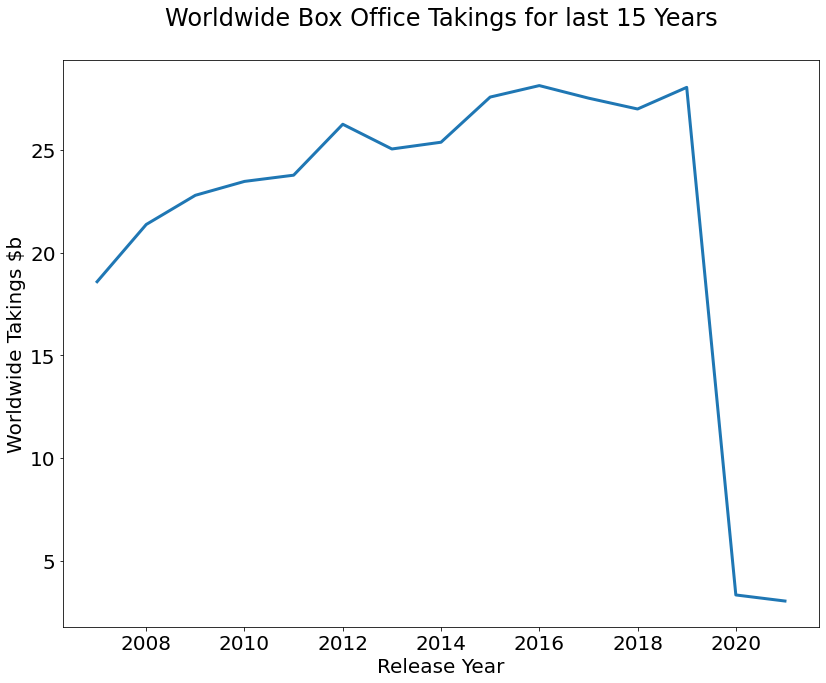

In [24]:
ww_df = financial_attributes_join.groupby('release_year').sum()
ww_df['worldwide_box_office_$'] = ww_df['worldwide_box_office_$']/1000000000
ww_df = ww_df[:15]
viz.lineplotter(ww_df, "release_year", "worldwide_box_office_$", 'Worldwide Box Office Takings for last 15 Years', 'Release Year', 'Worldwide Takings $b', 'images/worldwide_bo.png');


In [25]:
display(ww_df, ww_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 2007 to 2021
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   release_day             15 non-null     int64  
 1   budget_$                15 non-null     int64  
 2   domestic_box_office_$   15 non-null     int64  
 3   worldwide_box_office_$  15 non-null     float64
 4   profit_loss_$           15 non-null     int64  
 5   return_pct              15 non-null     float64
 6   domestic_%              15 non-null     float64
 7   Run_Time                15 non-null     float64
 8   MetacriticRating        15 non-null     float64
 9   RottenRating            15 non-null     float64
 10  imdbRating              15 non-null     float64
 11  imdb_votes              15 non-null     float64
 12  mean_rating             15 non-null     float64
dtypes: float64(9), int64(4)
memory usage: 1.6 KB


,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
release_year,,,,,,,,,,,,,
2007,2936,6976630000,8121804342,18.594419,11617789288,33253.242967,10151.155270,19544.0,9440.0,8838.0,12098.0,23367864.0,9535.000000
2008,3378,8030537890,9352055298,21.383221,13352682734,35333.586548,11339.375619,21299.0,9794.0,9655.0,12904.0,27340033.0,10293.666667
2009,3068,7766720000,9980939530,22.805599,15038879029,28753.478336,10271.173191,19108.0,8986.0,8989.0,11549.0,23619802.0,9515.333333
2010,3522,8751057650,9933489534,23.482657,14731599105,40711.690086,11265.837615,22078.0,10356.0,10380.0,13534.0,27131966.0,10769.666667
2011,3202,8326600000,9431044533,23.785698,15459098391,39540.395299,9789.825432,20319.0,9975.0,10097.0,12128.0,27040953.0,10488.666667
2012,2958,8269700000,10362130413,26.267858,17998158372,45058.780565,8614.097836,18684.0,8779.0,8819.0,11344.0,28640619.0,9191.666667
2013,2835,8295150000,10032121806,25.062920,16767769514,41809.839097,8281.527381,17615.0,8084.0,8299.0,10592.0,28041292.0,8618.333333
2014,2804,7571300000,10108335835,25.392078,17820777665,51749.612337,8594.871000,18424.0,8774.0,8847.0,10850.0,28080351.0,9369.333333
2015,3064,8104445600,10573282928,27.592869,19488423537,40979.373901,8865.675193,19931.0,9235.0,9675.0,11885.0,22110544.0,9813.333333


None

<font color='red'>**Despite a steady rise since 2007, takings were almost totally wiped out by the lockdowns, and have yet to tick up again. With many large markets still in and out of lockdown, there is little chance of turning a profit until there is more stability**</font> 

**Make a bar chart showing the best profit ranked films by genre**

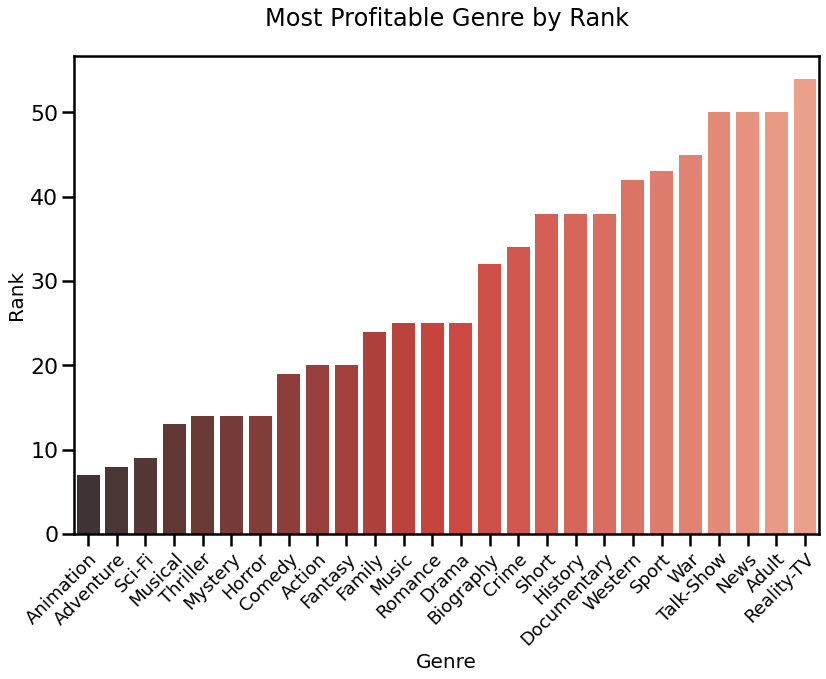

In [27]:
genre_df = dprep.ranked_df_maker(['Genre_List'], financial_attributes_join) 
genre_df = genre_df.reset_index()
# filter out any movies where genre list is blank
genre_df = genre_df[genre_df.Genre_List != 'N/A']
viz.rank_seaborn_bar(genre_df, 'Genre_List', 'Genre', "Most Profitable Genre by Rank", 'images/genre_rank.png');


In [28]:
display(genre_df.head(), genre_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 1 to 26
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre_List              26 non-null     object 
 1   budget_$                26 non-null     float64
 2   domestic_box_office_$   26 non-null     float64
 3   worldwide_box_office_$  26 non-null     float64
 4   profit_loss_$           26 non-null     float64
 5   return_pct              26 non-null     float64
 6   domestic_%              26 non-null     float64
 7   Counts                  26 non-null     float64
 8   return_p_rank           26 non-null     int32  
 9   gross_prof_rank         26 non-null     int32  
 10  combined_rank           26 non-null     int32  
dtypes: float64(7), int32(3), object(1)
memory usage: 2.1+ KB


,Genre_List,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
1,Animation,8.923014e+07,1.216178e+08,3.298629e+08,2.406328e+08,265.739632,40.405044,178.0,5,2,7
2,Adventure,1.017875e+08,1.227641e+08,3.480669e+08,2.462795e+08,229.833362,40.303792,549.0,7,1,8
3,Sci-Fi,9.167873e+07,1.148602e+08,3.120811e+08,2.204024e+08,248.374968,42.570276,194.0,6,3,9
4,Musical,4.810882e+07,8.032948e+07,2.186424e+08,1.705336e+08,219.293507,53.723431,17.0,8,5,13
5,Thriller,3.431887e+07,4.302726e+07,1.092135e+08,7.489461e+07,331.864104,48.842276,356.0,4,10,14


None

<font color='red'>**For all the rank charts, with red bars, the combined rank is the gross profit ranking plus ROI ranking, so the lower the bar the better**

**Animation, Adventure, Sci-Fi, Horror, Mystery and Thriller are the 6 best performing genres at the box office. This combines gross takings and return on investment, so we need to dig into which fits our needs the best** </font> 

**Make grouped bar chart showing number of hits and flops for major genres**

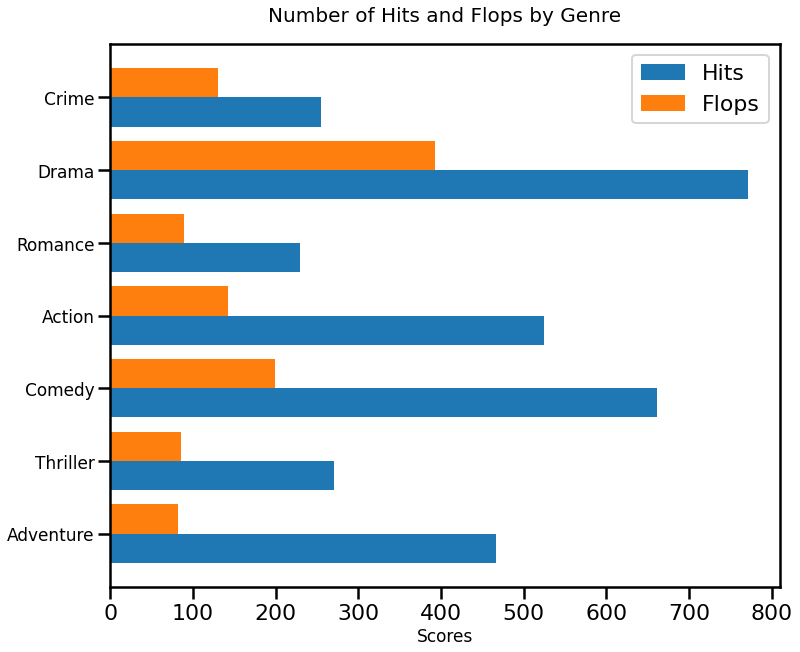

In [29]:
filtered_concat_gen_df = dprep.make_profit_loss_df(financial_attributes_join, financial_attributes_flops_join, financial_attributes_hits_join)
viz.grouped_bar_genre(filtered_concat_gen_df)

In [30]:
display(filtered_concat_gen_df.head(), filtered_concat_gen_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Genre_List   7 non-null      object 
 1   All_Counts   7 non-null      float64
 2   Flop_Counts  7 non-null      float64
 3   Hit_Counts   7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 352.0+ bytes


,Genre_List,All_Counts,Flop_Counts,Hit_Counts
0,Adventure,549.0,82.0,467.0
1,Thriller,356.0,85.0,271.0
2,Comedy,860.0,199.0,661.0
3,Action,668.0,143.0,525.0
4,Romance,319.0,89.0,230.0


None

<font color='red'>**Being a new studio, a top priority is not making a flop first out. Of the popular genres, Crime and Drama present the most risk of a flop, with adventure the least. Action, Thrillers and Comedies all present good odds of turning a profit**  </font> 

**Make bar chart showing mean budget per genre**

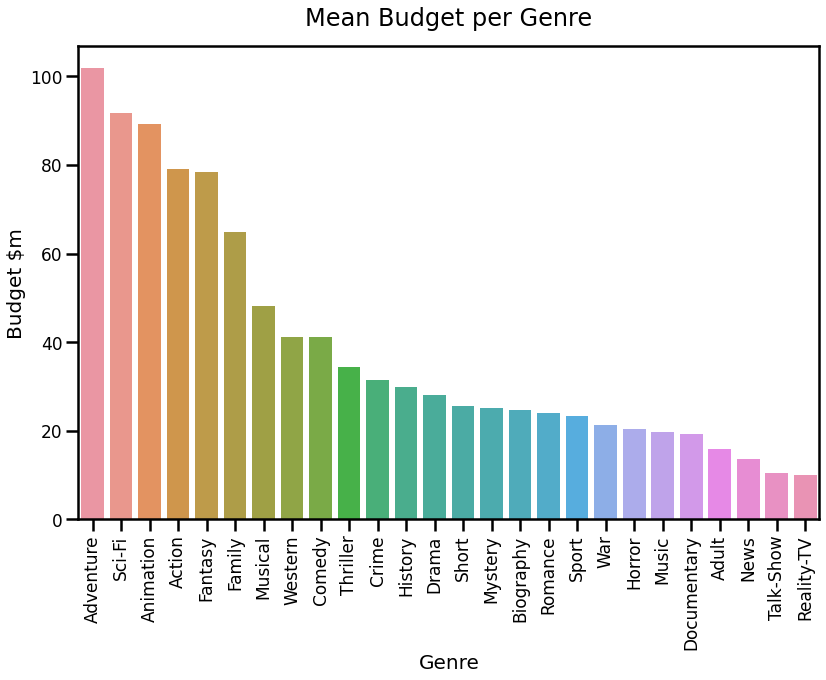

In [31]:
viz.budget_profit_bar(genre_df)

<font color='red'>**We also need to take into account the budget. The high budgets of Adventure, Sci-Fi, Action and Fantasy movies present risks of losses that could end the studio after one movie, something best to be avoided first up, but an avenue to maybe explore once the studio is more established** </font> 

**Make grouped bar chart showing gross profits and losses for major genres**

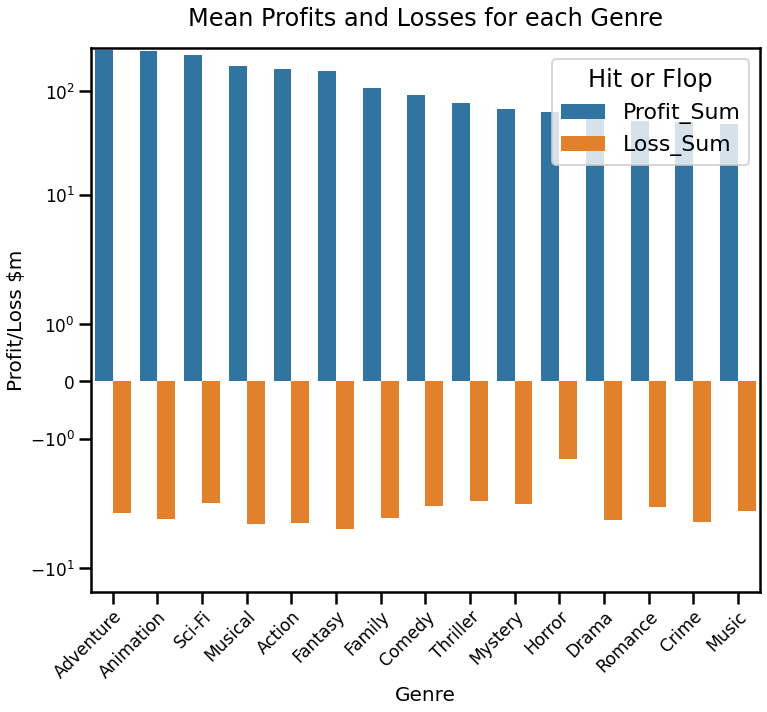

In [32]:
viz.p_l_gross_group_bar(financial_attributes_join)

<font color='red'>**Note that the y-scale is log, so the chances of making money are better than at first glance!**

**But this graph is helpful in showing the mean average loss that a loss-making film in each genre makes. Fantasy, Action and Musicals all tend to lose big, if they lose, while Sci-Fi, Thrillers, Horror and Mystery tend to have more sustainable losses, particularly Horror.** </font> 

**Make box plot to show the variance in gross profit and loss by genre**

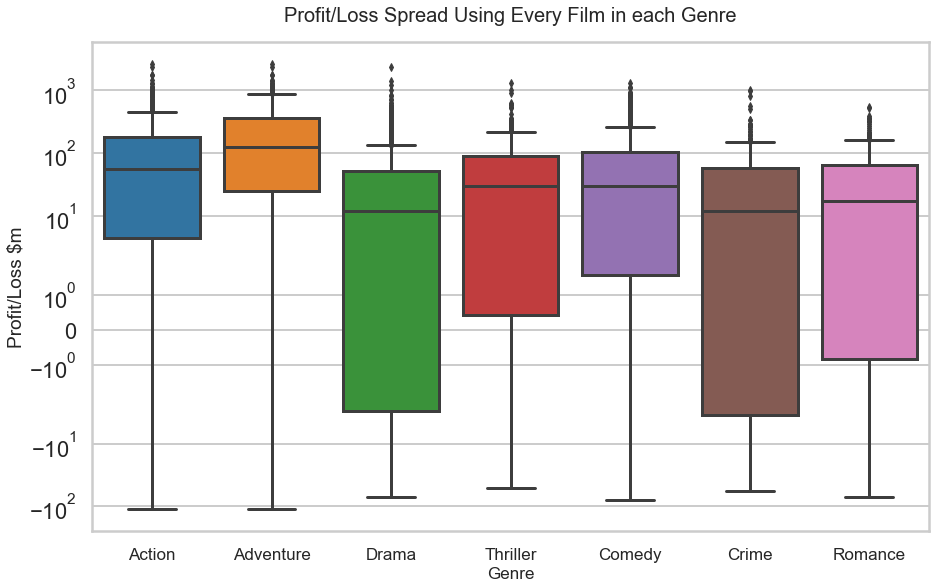

In [33]:
viz.profit_box_plot(financial_attributes_join)

<font color='red'>**This can also be seen in the box plot above, which demonstrates the spread of the fortunes that have been won and lost by films in each genre, with the box representing the most likely result.**
    
**Action and Adventure both have long tails, showing how much can be lost, even though they tend to turn more gross profit. These are both consequences of the large budgets involved**
    
**Thrillers lost the least, on average, and held their own in the upper reaches, with only costly Action and Adventures showing a clear advantage***
    
**Taking into account the likelihood in turning a profit, limited potential losses, realistic budget for a new studio and the reasonable potential at making a solid hit, Thrillers represents a good all round choice for early movies**
</font> 

**Now we've made a decision that thriller is the best all round choice we focus on the hits_df as we want to find what makes a profitable movie in the genre**

**Firstly we make a lineplot showing the returns of films by budget, split into thrillers and non thrillers**

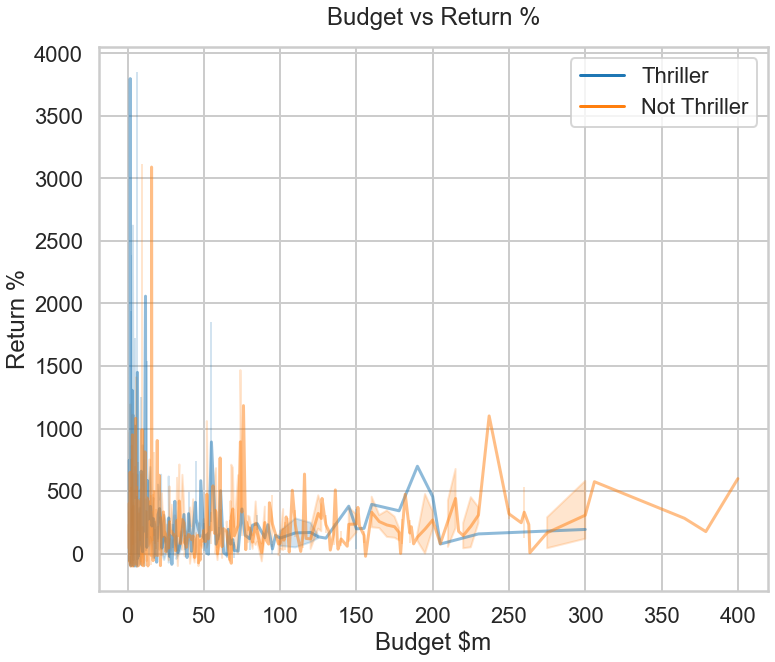

In [34]:
viz.budget_line(financial_attributes_join)

<font color='red'>**The blue line shows the return on budget for Thrillers, and the orange line every other movie. We can see the blue spikes are generally further left, showing that they are efficient at turning a profit at modest budgets**
    
**There is a spike very close to zero, which represents unlikely shoestring hits, and not something to affect our choice.**
    
**The spikes rise between around 20 and 50 million, before falling away, representing the type of budget we should be looking at**
</font> 

**Make a barchart showing the best profit ranked subgenres withing he thriller genre** 

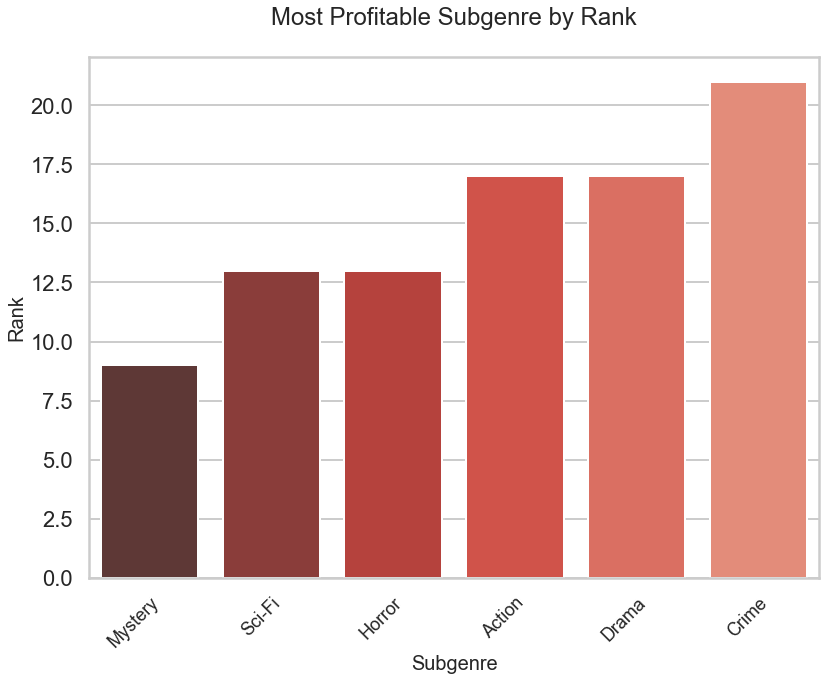

In [35]:
# creates a dataframe only showing hit thrillers
thriller_df = dprep.ranked_df_maker(['Genre_List'], financial_attributes_hits_join, ['Thriller'])  
thriller_df_sub = thriller_df.reset_index()
thriller_df_sub = thriller_df_sub[(thriller_df_sub['Genre_List'] != 'Thriller') & (thriller_df_sub['Counts'] > 20)]
viz.rank_seaborn_bar(thriller_df_sub, 'Genre_List', 'Subgenre', "Most Profitable Subgenre by Rank", 'images/subgenre_rank.png');

In [36]:
display(thriller_df_sub.head(), thriller_df_sub.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 11
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre_List              6 non-null      object 
 1   old_index               6 non-null      float64
 2   budget_$                6 non-null      float64
 3   domestic_box_office_$   6 non-null      float64
 4   worldwide_box_office_$  6 non-null      float64
 5   profit_loss_$           6 non-null      float64
 6   return_pct              6 non-null      float64
 7   domestic_%              6 non-null      float64
 8   Counts                  6 non-null      float64
 9   return_p_rank           6 non-null      int32  
 10  gross_prof_rank         6 non-null      int32  
 11  combined_rank           6 non-null      int32  
dtypes: float64(8), int32(3), object(1)
memory usage: 552.0+ bytes


,Genre_List,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
2,Mystery,1200.885246,1.927357e+07,5.346059e+07,1.160505e+08,9.677690e+07,983.042013,48.101700,61.0,1,8,9
5,Sci-Fi,810.269231,5.051731e+07,5.307698e+07,1.539202e+08,1.034029e+08,403.452870,41.126515,26.0,7,6,13
6,Horror,1295.837838,1.456216e+07,4.484242e+07,9.272793e+07,7.816577e+07,903.641251,52.291493,74.0,2,11,13
7,Action,666.846154,6.210726e+07,6.589092e+07,1.911395e+08,1.290323e+08,215.677762,42.037011,117.0,13,4,17
8,Drama,1068.506849,2.711010e+07,4.498699e+07,1.073261e+08,8.021602e+07,392.179447,46.299776,73.0,8,9,17


None

<font color='red'>**Being quite a wide genre, we need to concentrate on what type of Thrillers we should make. This ranked bar graph shows that Mystery, Horror and Sci-Fi all perform very well. Given Sci-Fi's high budgets, a Thriller/Mystery/Horror movie is the best option for a debut**</font> 

**We make a decision for a Thriller/Mystery/Horror due to all count and rank combination**



<img src="images/scared.jpg" style="width: 700px;"/>

**Now find attributes most commonly associated with profitable movies in that genre**

**Make scatterplot showing return on budget for thrillers, showing values for each subgenre**


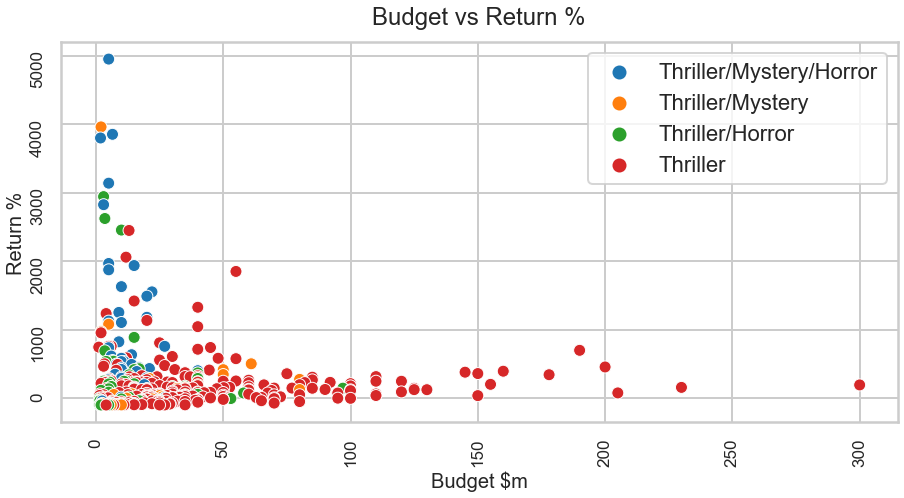

In [37]:
# make a clean thriller dataframe, not joined by genre 
add_thriller_list=[]
for index, row in financial_attributes_join.iterrows():
    if 'Thriller' in row['Genre_List']:
        add_thriller_list.append(row)
thriller_all = pd.DataFrame(add_thriller_list)
thriller_all_s = dprep.budget_prep(thriller_all)
thriller_all_s
viz.budget_sub_scatter(thriller_all_s)

In [38]:
display(thriller_all_s.head(), thriller_all_s.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 2069 to 2200
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               355 non-null    object 
 1   title                   355 non-null    object 
 2   release_year            355 non-null    int64  
 3   release_month           355 non-null    object 
 4   release_day             355 non-null    int64  
 5   budget_$                355 non-null    float64
 6   domestic_box_office_$   355 non-null    int64  
 7   worldwide_box_office_$  355 non-null    int64  
 8   profit_loss_$           355 non-null    int64  
 9   return_pct              355 non-null    float64
 10  domestic_%              355 non-null    float64
 11  Genre_List              355 non-null    object 
 12  Actor_List              355 non-null    object 
 13  Director_List           355 non-null    object 
 14  Writer_List             355 non-null  

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating,subgenre
2069,tt5052448,Get Out,2017,Feb,24,5.0,176040665,252500135,247500135,4950.002700,...,[Jordan Peele],[Jordan Peele],R,104.0,85.0,98.0,77.0,529995.0,86.666667,Thriller/Mystery/Horror
2309,tt0405094,Das Leben der Anderen,2007,Feb,9,2.0,11284657,81197047,79197047,3959.852350,...,[Florian Henckel von Donnersmarck],[Florian Henckel von Donnersmarck],R,137.0,89.0,92.0,84.0,372762.0,88.333333,Thriller/Mystery
2000,tt3322940,Annabelle,2014,Oct,3,6.5,84273813,256862920,250362920,3851.737231,...,[John R. Leonetti],[Gary Dauberman],R,99.0,37.0,29.0,54.0,149887.0,40.000000,Thriller/Mystery/Horror
2352,tt1320244,The Last Exorcism,2010,Aug,27,1.8,41034350,70165900,68365900,3798.105556,...,[Daniel Stamm],"[Huck Botko, Andrew Gurland]",PG-13,87.0,63.0,72.0,57.0,49001.0,64.000000,Thriller/Mystery/Horror
2071,tt2226417,Insidious Chapter 2,2013,Sep,13,5.0,83586447,161921515,156921515,3138.430300,...,[James Wan],"[Leigh Whannell, James Wan]",PG-13,106.0,40.0,39.0,66.0,162274.0,48.333333,Thriller/Mystery/Horror


None

<font color='red'>**Here we see the return per budget, with the blue dots representing the chosen genre. These spikes are clustered towards the lower end of our budget range, so we should be looking at the 20-30 million range**</font> 

**Make bar graphs of best profit ranked actors, directors and writers popular in the genre**


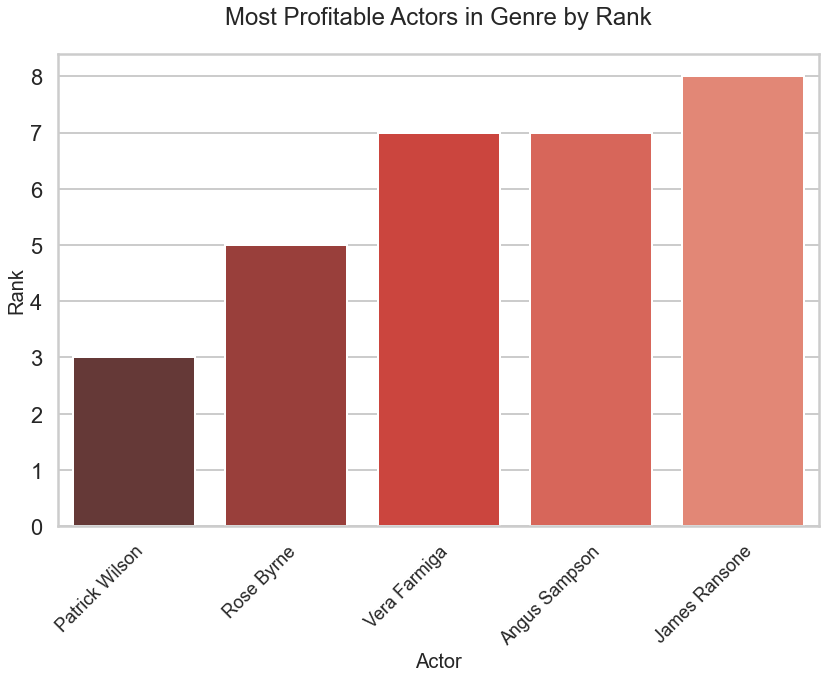

In [39]:
actor_df = dprep.ranked_df_maker(['Actor_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror']) 
actor_df=actor_df.reset_index()
actor_df = actor_df[actor_df.Actor_List != 'N/A']
viz.rank_seaborn_bar(actor_df, 'Actor_List', 'Actor', "Most Profitable Actors in Genre by Rank", 'images/actor_rank.png');

In [40]:
display(actor_df.head(), actor_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Actor_List              5 non-null      object 
 1   old_index               5 non-null      float64
 2   budget_$                5 non-null      float64
 3   domestic_box_office_$   5 non-null      float64
 4   worldwide_box_office_$  5 non-null      float64
 5   profit_loss_$           5 non-null      float64
 6   return_pct              5 non-null      float64
 7   domestic_%              5 non-null      float64
 8   Counts                  5 non-null      float64
 9   return_p_rank           5 non-null      int32  
 10  gross_prof_rank         5 non-null      int32  
 11  combined_rank           5 non-null      int32  
dtypes: float64(8), int32(3), object(1)
memory usage: 460.0+ bytes


,Actor_List,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
0,Patrick Wilson,1175.0,18700000.0,82942680.60,202200894.6,183500894.6,2468.448030,42.751170,5.0,2,1,3
1,Rose Byrne,1630.0,3250000.0,68797798.50,130896200.5,127646200.5,4848.244683,52.850278,2.0,1,4,5
2,Vera Farmiga,919.5,26750000.0,79678514.25,206995375.0,180245375.0,734.899481,40.215726,4.0,5,2,7
3,Angus Sampson,1360.0,10000000.0,59981944.00,146632563.0,136632563.0,1366.325630,41.276757,2.0,4,3,7
4,James Ransone,1512.0,6500000.0,37913929.00,70916016.0,64416016.0,1632.651242,53.043465,2.0,3,5,8


None

<font color='red'>**Patrick Wilson is ranked most profitable actor in the genre, but Rose Byrne and Vera Farmiga also score well**</font> 

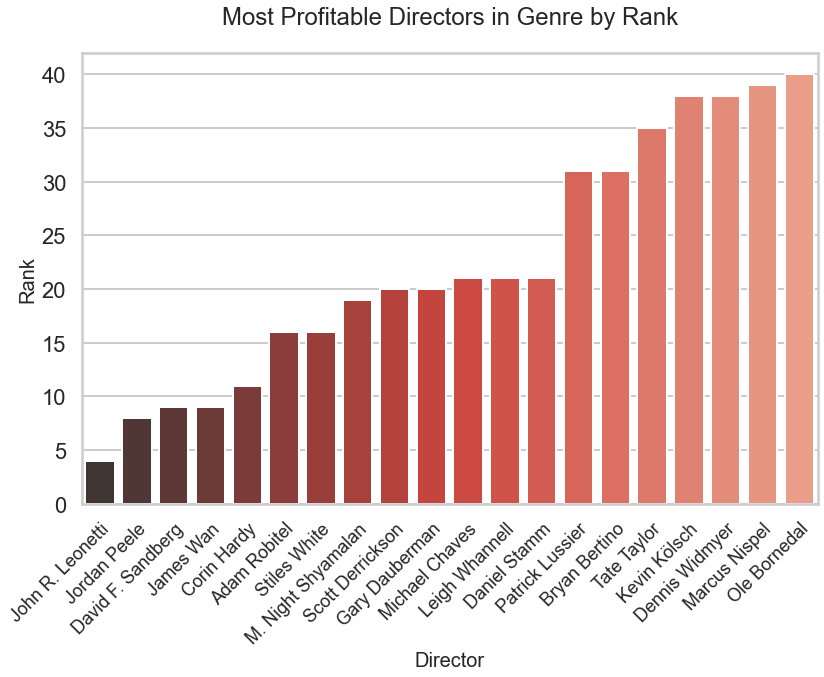

In [41]:
director_df = dprep.ranked_df_maker(['Director_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20] 
director_df = director_df.reset_index()
director_df = director_df[director_df.Director_List != 'N/A']
viz.rank_seaborn_bar(director_df, 'Director_List', 'Director', "Most Profitable Directors in Genre by Rank", 'images/director_rank.png');

In [42]:
display(director_df.head(), director_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Director_List           20 non-null     object 
 1   old_index               20 non-null     float64
 2   budget_$                20 non-null     float64
 3   domestic_box_office_$   20 non-null     float64
 4   worldwide_box_office_$  20 non-null     float64
 5   profit_loss_$           20 non-null     float64
 6   return_pct              20 non-null     float64
 7   domestic_%              20 non-null     float64
 8   Counts                  20 non-null     float64
 9   return_p_rank           20 non-null     int32  
 10  gross_prof_rank         20 non-null     int32  
 11  combined_rank           20 non-null     int32  
dtypes: float64(8), int32(3), object(1)
memory usage: 1.8+ KB


,Director_List,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
0,John R. Leonetti,1498.0,6.500000e+06,84273813.0,2.568629e+08,250362920.0,3851.737231,32.808867,1.0,1,3,4
1,Jordan Peele,1287.0,1.250000e+07,175562622.5,2.542960e+08,241796027.0,3065.231148,69.043452,2.0,4,4,8
2,David F. Sandberg,1198.0,1.500000e+07,102092201.0,3.053849e+08,290384865.0,1935.899100,33.430668,1.0,7,2,9
3,James Wan,1432.0,8.833333e+06,91665246.0,1.931789e+08,184345601.0,3728.403792,49.647634,3.0,3,6,9
4,Corin Hardy,1005.0,2.200000e+07,117450119.0,3.633916e+08,341391647.0,1551.780214,32.320533,1.0,10,1,11


None

<font color='red'>**As for director, John R. Leonetti, Jordan Peele and James Wan all look good choices**</font> 

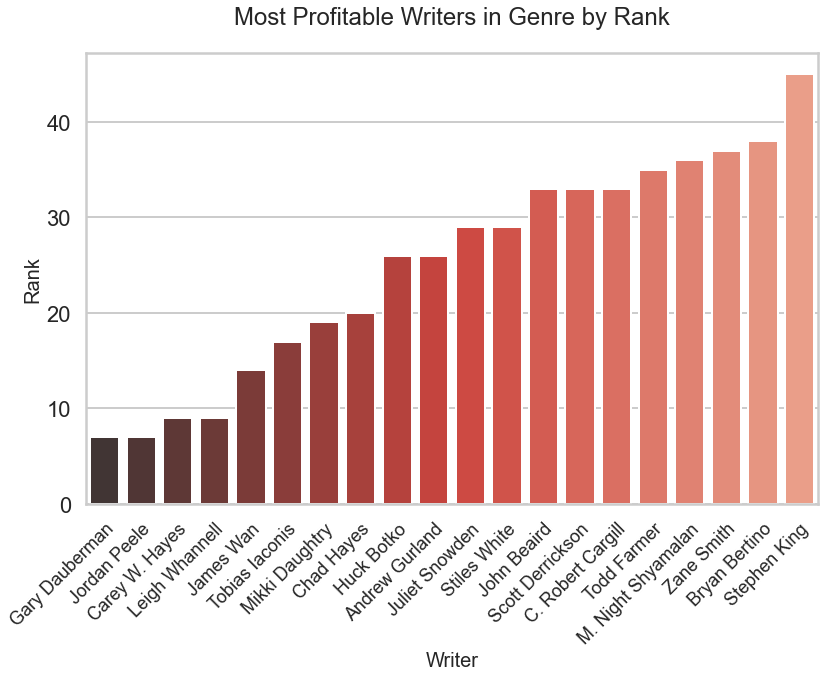

In [43]:
writer_df = dprep.ranked_df_maker(['Writer_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20]  
writer_df = writer_df.reset_index()
writer_df = writer_df[writer_df.Writer_List != 'N/A']
viz.rank_seaborn_bar(writer_df, 'Writer_List', 'Writer', "Most Profitable Writers in Genre by Rank", 'images/writer_rank.png');

In [44]:
display(writer_df.head(), writer_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Writer_List             20 non-null     object 
 1   old_index               20 non-null     float64
 2   budget_$                20 non-null     float64
 3   domestic_box_office_$   20 non-null     float64
 4   worldwide_box_office_$  20 non-null     float64
 5   profit_loss_$           20 non-null     float64
 6   return_pct              20 non-null     float64
 7   domestic_%              20 non-null     float64
 8   Counts                  20 non-null     float64
 9   return_p_rank           20 non-null     int32  
 10  gross_prof_rank         20 non-null     int32  
 11  combined_rank           20 non-null     int32  
dtypes: float64(8), int32(3), object(1)
memory usage: 1.8+ KB


,Writer_List,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
0,Gary Dauberman,1153.75,17625000.0,9.449218e+07,2.892230e+08,2.715980e+08,2023.976906,32.656424,4.0,5,2,7
1,Jordan Peele,1287.00,12500000.0,1.755626e+08,2.542960e+08,2.417960e+08,3065.231148,69.043452,2.0,4,3,7
2,Carey W. Hayes,1036.00,20000000.0,1.374001e+08,3.177444e+08,2.977444e+08,1488.722010,43.242348,1.0,8,1,9
3,Leigh Whannell,1495.00,6625000.0,6.438987e+07,1.387644e+08,1.321394e+08,3107.285157,47.063517,4.0,3,6,9
4,James Wan,1031.50,23500000.0,8.518856e+07,2.391952e+08,2.156952e+08,1461.809822,37.188765,4.0,9,5,14


None

<font color='red'>**Jordan Peele and James Wan both score highly once again, and either presents a good choice to write and direct the film**</font> 

**Make subplots showing the relative perfomances of the best performing crew members in the genre**

In [45]:
top_full_crew_df = dprep.make_crew_df(financial_attributes_join)


In [47]:
display(top_full_crew_df.head(), top_full_crew_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 69 to 2364
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_code               53 non-null     object 
 1   title                   53 non-null     object 
 2   release_year            53 non-null     int64  
 3   release_month           53 non-null     object 
 4   release_day             53 non-null     int64  
 5   budget_$                53 non-null     int64  
 6   domestic_box_office_$   53 non-null     int64  
 7   worldwide_box_office_$  53 non-null     int64  
 8   profit_loss_$           53 non-null     int64  
 9   return_pct              53 non-null     float64
 10  domestic_%              53 non-null     float64
 11  Genre_List              53 non-null     object 
 12  Actor_List              53 non-null     object 
 13  Director_List           53 non-null     object 
 14  Writer_List             53 non-null     o

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
69,tt2820852,Furious 7,2015,Apr,1,190000000,353007020,1516881526,1326881526,698.358698,...,"[Vin Diesel, Paul Walker, Dwayne Johnson]",[James Wan],"[Chris Morgan, Gary Scott Thompson]",PG-13,137.0,67.0,82.0,71.0,374621.0,73.333333
122,tt3741700,Godzilla: King of the Monsters,2019,May,29,170000000,110500138,383299915,213299915,125.470538,...,"[Kyle Chandler, Vera Farmiga, Millie Bobby Brown]",[Michael Dougherty],"[Michael Dougherty, Zach Shields, Max Borenstein]",PG-13,132.0,48.0,42.0,60.0,166514.0,50.000000
135,tt1477834,Aquaman,2018,Dec,6,160000000,335061807,1143758700,983758700,614.849188,...,"[Jason Momoa, Amber Heard, Willem Dafoe]",[James Wan],"[David Leslie Johnson-McGoldrick, Will Beall, ...",PG-13,143.0,55.0,65.0,69.0,415156.0,63.000000
201,tt0409459,Watchmen,2009,Mar,6,138000000,107509799,186976250,48976250,35.490036,...,"[Jackie Earle Haley, Patrick Wilson, Carla Gug...",[Zack Snyder],"[Dave Gibbons, David Hayter, Alex Tse]",R,162.0,56.0,65.0,76.0,525899.0,65.666667
309,tt6924650,Midway,2019,Nov,7,100000000,56846802,126829063,26829063,26.829063,...,"[Ed Skrein, Patrick Wilson, Woody Harrelson]",[Roland Emmerich],[Wes Tooke],PG-13,138.0,47.0,42.0,67.0,75297.0,52.000000


None

In [48]:
top_actors = ['Rose Byrne', 'Vera Farmiga', 'Patrick Wilson', 'Angus Sampson', 'James Ransone']
top_directors = ['John R. Leonetti', 'Jordan Peele', 'James Wan', 'David F. Sandberg', 'Corin Hardy']
top_writers = ['Gary Dauberman', 'Leigh Whannell', 'Carey W. Hayes', 'Jordan Peele', 'James Wan']

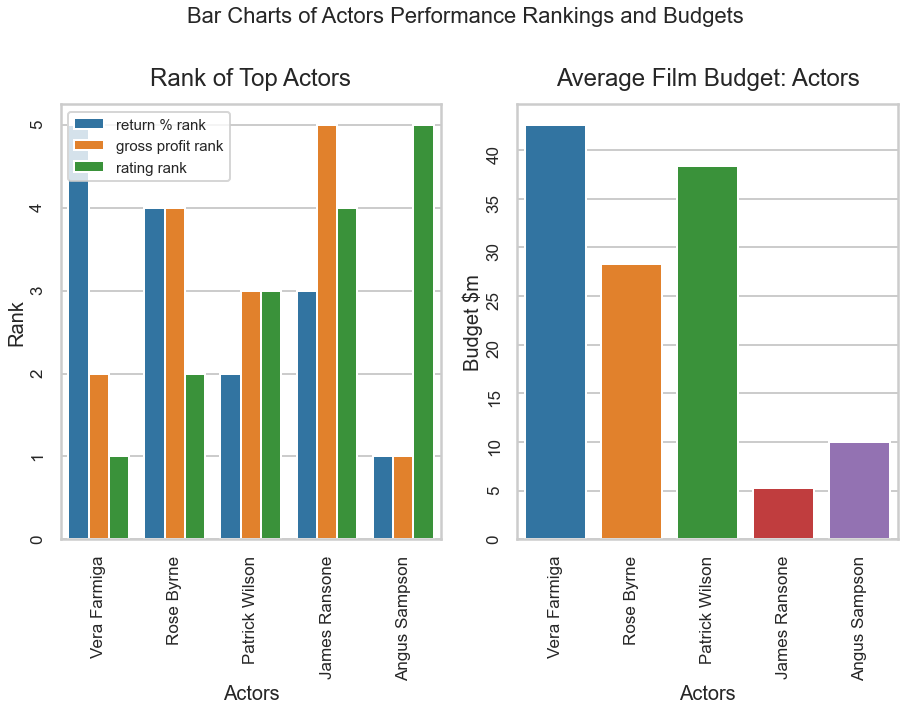

In [49]:
act_group = viz.graph_generator(top_full_crew_df, 'Actor_List', top_actors, 'Actors')

<font color='red'>**We look at the user ratings for the first time, and notice little link among the top actors between critical praise and box office returns, with the most profitable actor ranking last in ratings, and the best rated actress the least profitable, in terms or ROI.**

**Rose Byrne gets good all round scores, along with Patrick Wilson, but operates more within the decided budget range. Although we are looking primarily at the box office, we still need to consider the critical reception as the studio builds a reputation.** </font> 

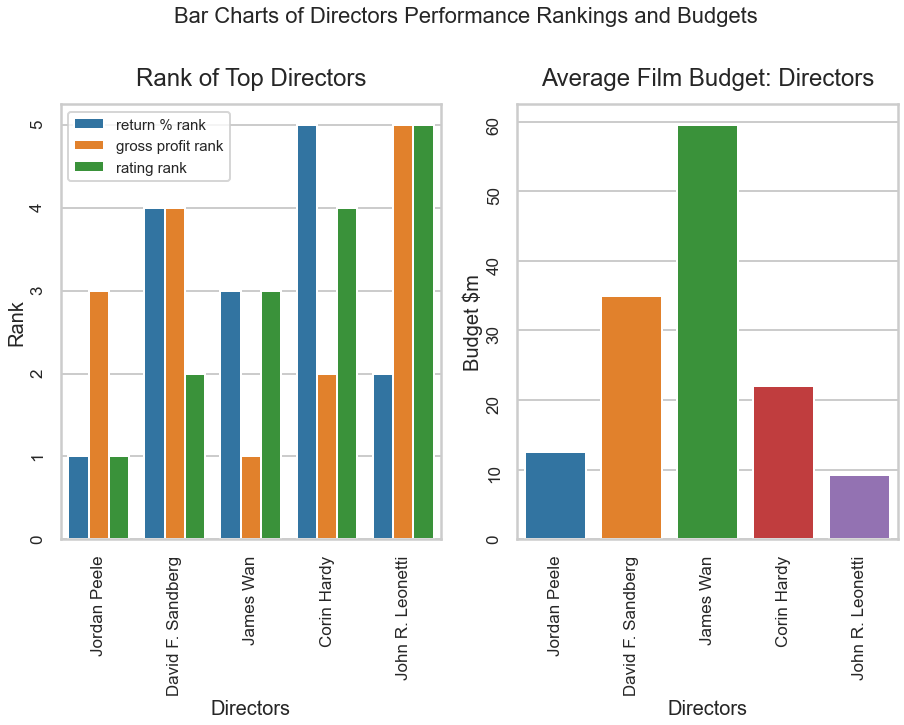

In [50]:
dir_group = viz.graph_generator(top_full_crew_df, 'Director_List', top_directors, 'Directors')

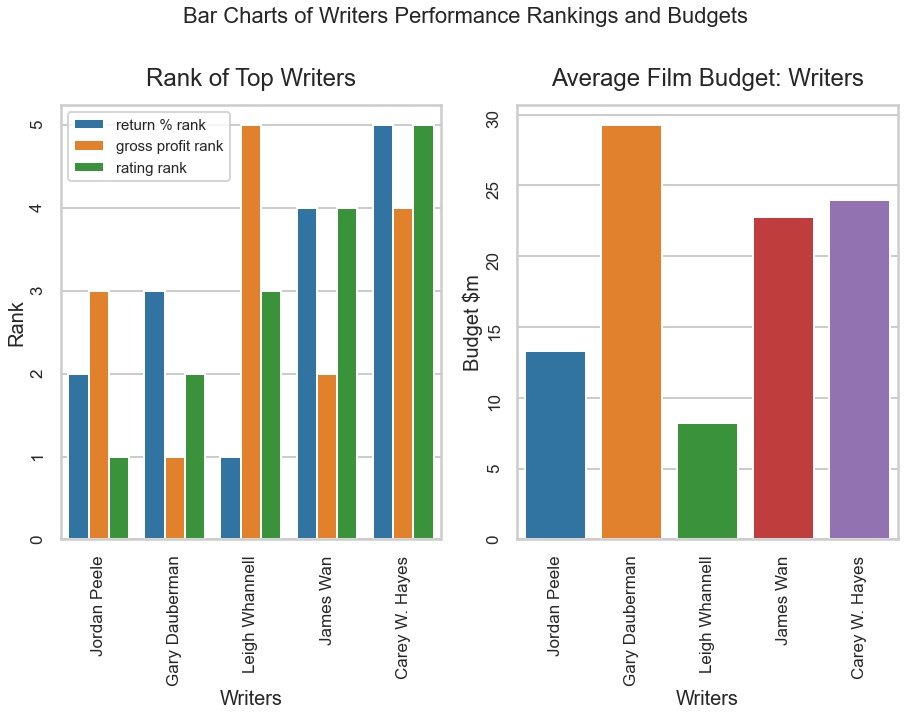

In [51]:
writer_group = viz.graph_generator(top_full_crew_df, 'Writer_List', top_writers, 'Writers')

<font color='red'>**Jordan Peele is the standout choice for writer and director in terms of both profitability and critical success. He also is used to working at the lower end of our budget range, so makes the ideal choice**</font> 

**Make plot to see link between user ratings and profitability**

**Make ranked bar charts showing most profitable runtime, rated, ratings and release month**


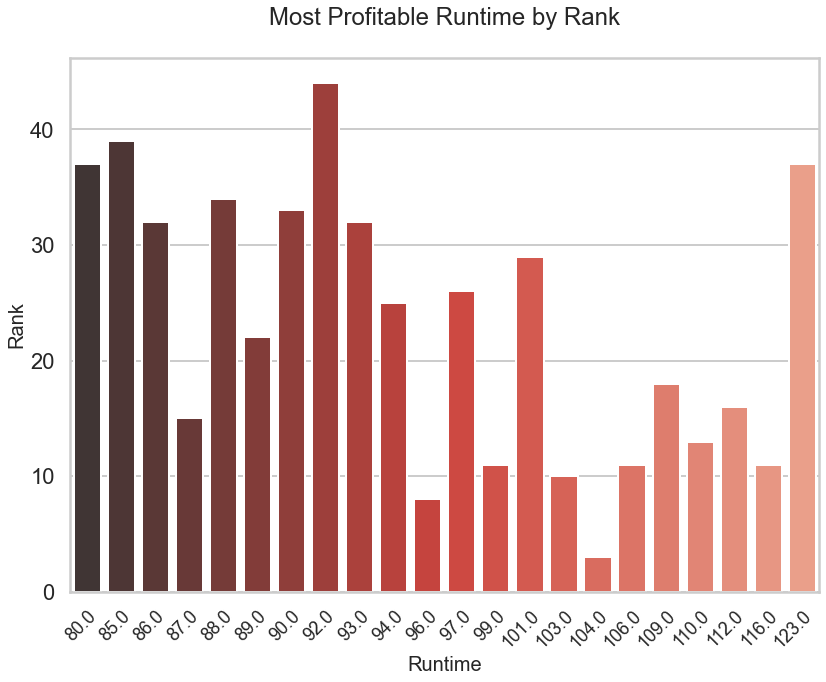

In [52]:
runtime_df = dprep.ranked_df_maker(['Run_Time'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
runtime_df = runtime_df.reset_index()
runtime_df = runtime_df.sort_values(by='Run_Time')
viz.rank_seaborn_bar(runtime_df, 'Run_Time', 'Runtime', "Most Profitable Runtime by Rank", 'images/runtime_rank.png');

In [53]:
display(runtime_df.head(), runtime_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 19 to 18
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Run_Time                22 non-null     float64
 1   old_index               22 non-null     float64
 2   budget_$                22 non-null     float64
 3   domestic_box_office_$   22 non-null     float64
 4   worldwide_box_office_$  22 non-null     float64
 5   profit_loss_$           22 non-null     float64
 6   return_pct              22 non-null     float64
 7   domestic_%              22 non-null     float64
 8   Counts                  22 non-null     float64
 9   return_p_rank           22 non-null     int32  
 10  gross_prof_rank         22 non-null     int32  
 11  combined_rank           22 non-null     int32  
dtypes: float64(9), int32(3)
memory usage: 2.0 KB


,Run_Time,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
19,80.0,1370.0,10000000.0,33679655.0,63354114.0,53354114.0,533.541140,53.160960,1.0,17,20,37
20,85.0,1454.0,8000000.0,25928550.0,47782426.0,39782426.0,497.280325,54.263779,1.0,18,21,39
15,86.0,1466.5,7500000.0,33716892.0,62962703.0,55462703.0,718.679283,48.967765,2.0,13,19,32
7,87.0,1710.0,1800000.0,41034350.0,70165900.0,68365900.0,3798.105556,58.481898,1.0,3,12,15
17,88.0,1178.0,16000000.0,42670410.0,78208812.0,62208812.0,388.805075,54.559594,1.0,20,14,34


None

<font color='red'>**Movies should be between 96 and 110 minutes long, as that's where the best performing movies in the genre are concentrated**</font> 

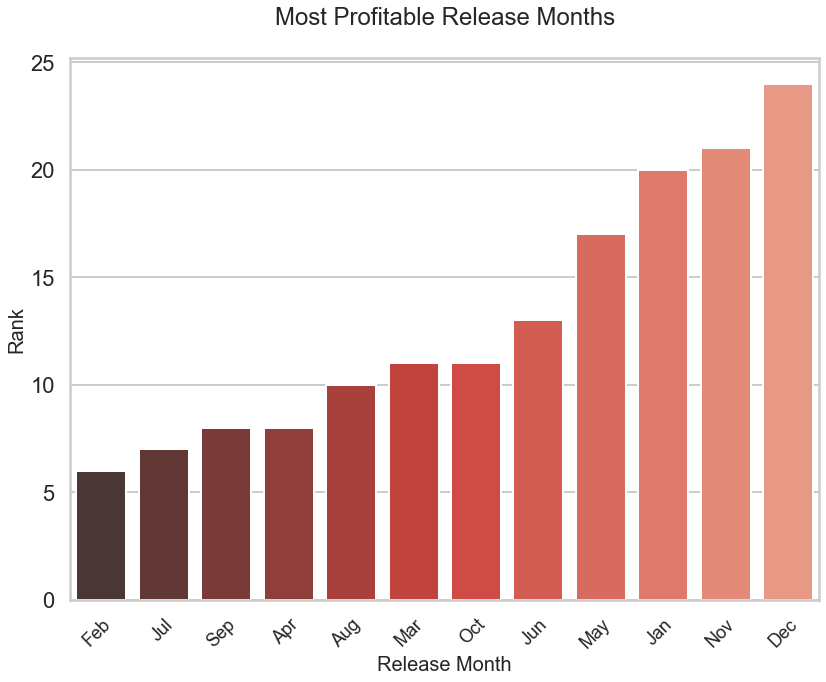

In [54]:
release_month_df = dprep.ranked_df_maker(['release_month'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
release_month_df=release_month_df.reset_index()
viz.rank_seaborn_bar(release_month_df, 'release_month', 'Release Month', "Most Profitable Release Months", 'images/month_rank.png');

In [55]:
display(release_month_df.head(), release_month_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   release_month           12 non-null     object 
 1   old_index               12 non-null     float64
 2   budget_$                12 non-null     float64
 3   domestic_box_office_$   12 non-null     float64
 4   worldwide_box_office_$  12 non-null     float64
 5   profit_loss_$           12 non-null     float64
 6   return_pct              12 non-null     float64
 7   domestic_%              12 non-null     float64
 8   Counts                  12 non-null     float64
 9   return_p_rank           12 non-null     int32  
 10  gross_prof_rank         12 non-null     int32  
 11  combined_rank           12 non-null     int32  
dtypes: float64(8), int32(3), object(1)
memory usage: 1.1+ KB


,release_month,old_index,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,domestic_%,Counts,return_p_rank,gross_prof_rank,combined_rank
0,Feb,1273.666667,1.366667e+07,9.338876e+07,1.338720e+08,1.202053e+08,1864.067833,69.724835,3.0,2,4,6
1,Jul,1049.500000,2.000000e+07,8.949820e+07,1.982569e+08,1.782569e+08,891.284575,48.024978,2.0,6,1,7
2,Sep,1369.400000,1.040000e+07,6.413988e+07,1.452661e+08,1.348661e+08,1477.432749,51.295420,5.0,5,3,8
3,Apr,1387.666667,1.050000e+07,5.448920e+07,1.111140e+08,1.006140e+08,2747.426547,49.337347,3.0,1,7,8
4,Aug,1419.400000,9.160000e+06,4.824408e+07,1.108808e+08,1.017208e+08,1480.770022,50.634918,5.0,4,6,10


None

<font color='red'>**Halloween isn't particularly good for films in our genre, instead February and July score the best. Along with the recovery from the pandemic, the best release dates would be July 2022 or February 2023, lockdowns depending**</font> 

**Make plot showing yearly trend of total takings by every genre, and by thriller/horror**

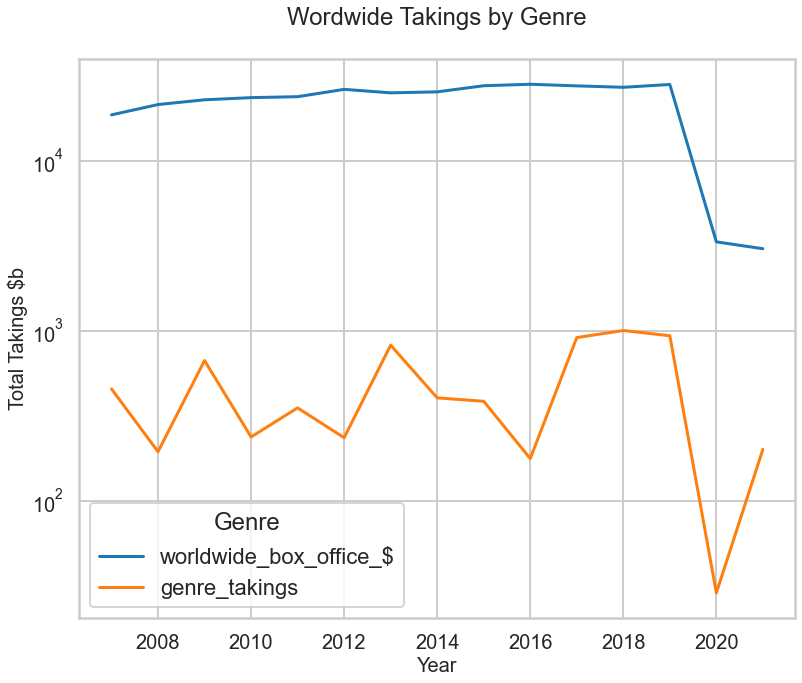

In [56]:
viz.overall_time_trend(financial_attributes_join)

<font color='red'>**We're again using a log scale, to make it easier to see the trend of our genre vs the general trend**

**There are early signs that the genre is outperforming the pack as life opens up again, having seen a recovery this year**</font> 

**Make ranked bar graph of best performing movies in the genre over last 15 years**

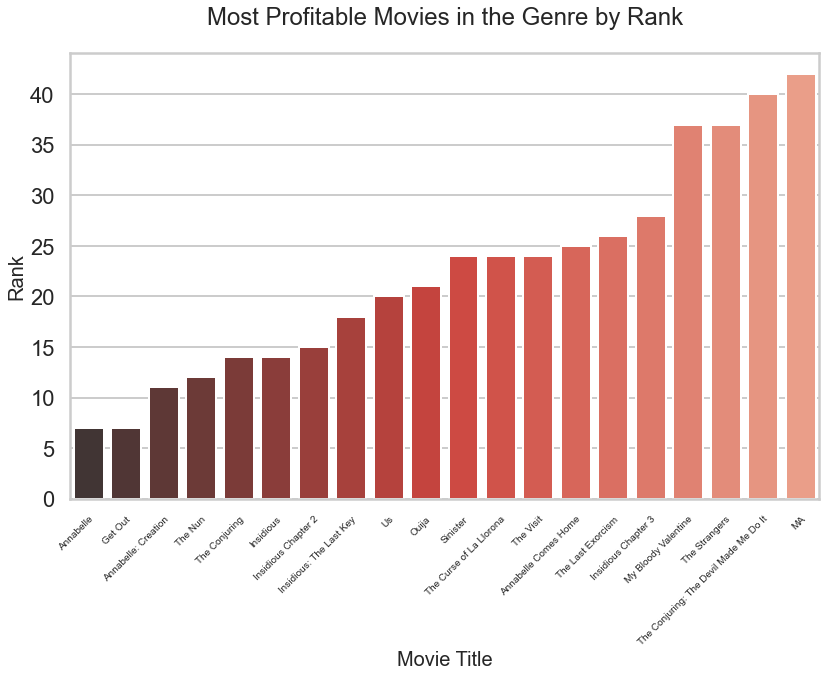

In [57]:
viz.best_genre_films(financial_attributes_join)

<font color='red'>**Here we see the best perfoming films in the genre too get an idea of the type of film that has performed well in recent years**
**Jordan Peele scores highly with both 'Get Out' and 'Us'**</font> 

<font color='red'>**BONUS TIP! - Here are the keywords associated with the best ranking films in the genre. A credit stinger could be a good idea!**</font> 

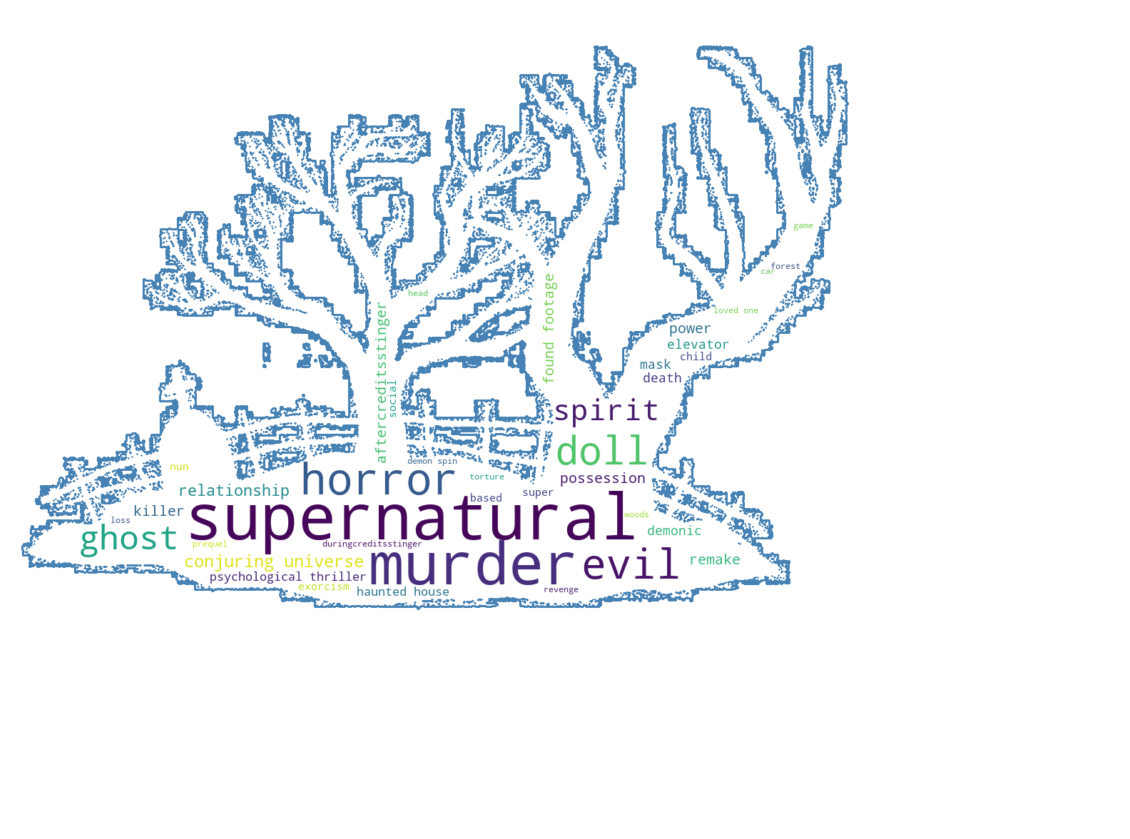

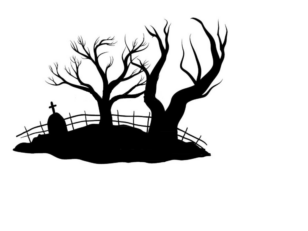

In [29]:
text = dprep.omdb_genre_keywords(financial_attributes_hits_join, tmdb_key)
viz.wordcloud(text)

## Conclusions

This analysis leads to three recommendations for maximising the chances of producing successful movies:

**Timing - The first movies should be released in July 2022 and February 2023** - subject to the pandemic

**Personnel - The studio should recruit Jordan Peele to write and direct, with Rose Byrne and Patrick Wilson both good choices as lead actors**

**Attributes - Early movies should be Thrillers, with the debut in the Mystery/Horror subgenre. They should be between 96 and 110 minutes long with a budget of 20-30 million dollars. The studio can move into Action/Adventure once established.**

## Next steps

The results show that certain attributes do tend to increase the chances of success, but we would need to do some more analysis to quantify which features have the most weight 

I made the assumption that genre was the most important factor, as that seems intuitive, but a more comprehensive model may show a stronger link between the lead actors or director and success

It is also difficult to quantify the power of an established brand, a lot of the top ranking films are part of a 'universe', such as Marvel or DC, that have decades of recognition to draw on. More data on movies made by studios in similar circumstances would be helpful

Given the movie industry is given to trends, like most creative industries, it is difficult to assert with full confidence that what held true over the last 15 years will continue to do so over the next 15 years

It seems likely that a global psychological event like the pandemic will affect what people want to watch, but not necessarily in a predictable way, and we should be gathering as much data as possible now people are returning to the cinema

We should commission surveys to try and capture the general mood of cinema-goers, something that can't be gleaned from the datasets we worked with

I would me moderately confident of making these recommendations; I believe they would maximise the chances of success while limiting the chances of a disastrous performance, at the expense of likely missing out on the blockbuster profits achieved by some of the franchises. These can be targetted once the studio has established itself